In [1]:
!pip install wandb

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m013 (ma23m013-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Question-1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


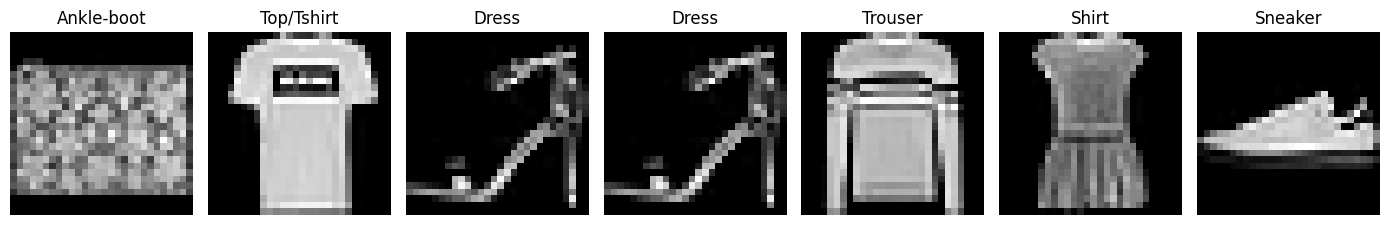

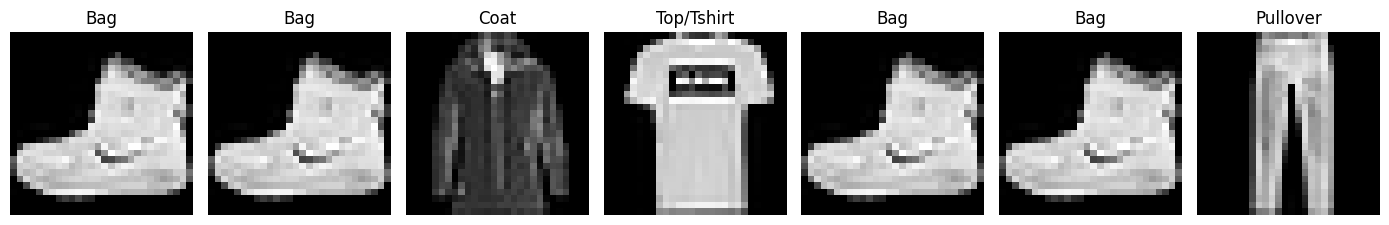

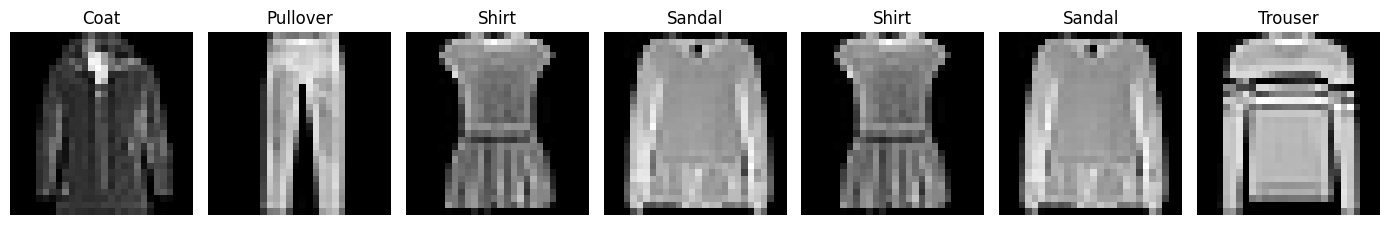

In [4]:
# Initialize WandB project
wandb.init(project='DA6401_Assignment-1')

# Load Fashion-MNIST dataset (train and test sets)
(train_img, train_lbl), (test_img, test_lbl) = fashion_mnist.load_data()

# Define class names for labels
class_names = ['Top/Tshirt', 'Pullover', 'Trouser', 'Shirt', 'Coat', 'Dress', 'Sandal', 'Sneaker', 'Ankle-boot', 'Bag']

# Select one sample image for each class
samples = {}
for i in range(100):  # Loop through first 36 images
  lbl = train_lbl[i]  # Get label of current image
  if lbl not in samples:  # If label is not already added, add it
    samples[lbl] = train_img[i]
  if len(samples) == 10:  # Stop when all 10 classes have at least one image
    break

# Convert dictionary to lists for easy indexing
sample_lbl = list(samples.keys())
sample_img = list(samples.values())

# Function to plot 7 random sample images
def plot_sample(step):
  fig, axes = plt.subplots(1, 7, figsize=(14, 5))  # Create figure with 7 subplots
  chosen_indices = np.random.choice(len(sample_img), 7, replace=True)  # Randomly select 7 images

  for ax, idx in zip(axes.flatten(), chosen_indices):
    ax.imshow(sample_img[idx], cmap='gray')  # Display image
    ax.set_title(class_names[sample_lbl[idx]])  # Set title with class name
    ax.axis('off')  # Remove axis for cleaner view

  plt.tight_layout()
  plt.show()
  return fig

# Log images to WandB for visualization
wandb.log({"Examples": [wandb.Image(plot_sample(0), caption="Step 0"),
    wandb.Image(plot_sample(1), caption="Step 1"), wandb.Image(plot_sample(2), caption="Step 2")]})

# Finish WandB run
wandb.finish()


## Question-2

In [5]:

# Activation function (Sigmoid)
def act(x):
  return 1/(1+np.exp(-x))  # Converts input into a range between 0 and 1

# Derivative of Sigmoid, used in backpropagation to compute gradients
def act_der(x):
  return act(x)*(1-act(x))

# Softmax function, converts output layer activations into probabilities
def soft_func(x):
  x = x-np.max(x) # Normalize values to prevent overflow
  return np.exp(x)/np.sum(np.exp(x), axis=0)

# Initialize neural network weights and biases
def init_net(n_layers, nodes, init_m, inp_dim, out_dim):
  """
    Initializes the neural network weights and biases.

    Parameters:
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - init_m: Weight initialization method ('rand' or 'xav')
    - inp_dim: Input dimension
    - out_dim: Output dimension

    Returns:
    - Dictionary containing initialized weights and biases
    """
  size = [inp_dim]+nodes+[out_dim]  # Define the structure of the network
  wts = {}  # Dictionary to store weights and biases

  if init_m == 'rand': # Random weight initialization
    for i in range(1, n_layers+2):
      wts['W'+str(i)] = np.random.randn(size[i],size[i-1])
      wts['b'+str(i)] = np.random.randn(size[i],1)
  elif init_m == 'xav': # Xavier initialization for better weight scaling
    for i in range(1, n_layers+2):
      wts['W'+str(i)] = np.random.randn(size[i],size[i-1])*(np.sqrt(2/size[i-1]))
      wts['b'+str(i)] = np.random.randn(size[i],1)*(np.sqrt(2/size[i-1]))

  return wts

# Forward propagation - calculates activations layer by layer
def forw_prop(inp,wts, n_layers, inp_dim):
  """
    Performs forward propagation.

    Parameters:
    - inp: Input data
    - wts: Weights dictionary
    - n_layers: Number of hidden layers
    - inp_dim: Input dimension

    Returns:
    - acts: Dictionary storing activations
    - out: Dictionary storing outputs at each layer
    - pred: Output probabilities from the softmax layer
    """
  acts = {} # Store activation values
  acts['a0'] = np.zeros((inp_dim,1)) # Initialize first activation
  out = {'h0':inp} # Store input layer values

  for i in range(1,n_layers+1): # Iterate through hidden layers
    acts['a'+str(i)]= np.dot(wts['W'+str(i)], out['h'+str(i-1)]) + wts['b'+str(i)]
    out['h'+str(i)]= act(acts['a'+str(i)]) # Apply activation function
  # Output layer processing
  acts['a'+str(n_layers+1)]= np.dot(wts['W'+str(n_layers+1)], out['h'+str(n_layers)]) + wts['b'+str(n_layers+1)]
  pred = soft_func(acts['a'+str(n_layers+1)]) # Apply softmax for probabilities

  return acts, out, pred

# Backpropagation - calculates gradients for weight updates
def back_prop(inp, true_lbl, n_layers, wts, inp_dim):
  """
    Performs backpropagation to compute gradients.

    Parameters:
    - inp: Input data
    - true_lbl: True labels
    - n_layers: Number of hidden layers
    - wts: Weights dictionary
    - inp_dim: Input dimension

    Returns:
    - grad: Dictionary containing gradients for weight and bias updates
    """
  m = inp.shape[0] # Number of examples
  acts, out, pred = forw_prop(inp, wts, n_layers, inp_dim)
  grad = {} # Store gradients
  err = {} # Store error terms
  err['a'+str(n_layers+1)] = -1*(true_lbl.T-pred) # Compute error for output layer

  for i in range(n_layers+1,0,-1): # Iterate backwards through layers
    grad['W'+str(i)]= (1/m)*np.dot(err['a'+str(i)], out['h'+str(i-1)].T) # Compute weight gradient
    grad['b'+str(i)]= (1/m)*np.mean(err['a'+str(i)], axis=1, keepdims=True) # Compute bias gradient
    if i>1:
      err['h'+str(i-1)]= np.dot(wts['W'+str(i)].T, err['a'+str(i)]) # Propagate error backward
      err['a'+str(i-1)]= err['h'+str(i-1)]*act_der(acts['a'+str(i-1)]) # Apply derivative of activation
  return grad

# Gradient Descent with loss tracking
def upd_wts(lr, wts, inp, true_lbl, n_layers, inp_dim):
  wandb.init(project='DA6401_Assignment-1', name='GradientDescent')
  losses= []  # Store losses for each epoch
  for e in range(100): # Train for 100 epochs
    grad = back_prop(inp, true_lbl, n_layers, wts, inp_dim)
    for i in range (1, n_layers+2):
      wts['W'+str(i)] -= lr*grad['W'+str(i)] # Update weights
      wts['b'+str(i)] -= lr*grad['b'+str(i)] # Update biases

    # Compute loss for this epoch
    acts, out, pred = forw_prop(inp, wts, n_layers, inp_dim)
    loss = -np.mean(np.sum(true_lbl.T*np.log(pred),axis=0))
    losses.append(loss)
    wandb.log({'Epoch': e+1, 'Loss': loss})
    print(f'Epoch {e+1}, Loss: {loss}')

  # Plot the loss function over epochs
  plt.plot(losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.show()

  wandb.finish()
  return wts, losses

# Compute accuracy of the model
def calc_acc(test_inp, test_lbl, wts, n_layers, inp_dim):
  acts, out, pred = forw_prop(test_inp, wts, n_layers, inp_dim)
  assert test_lbl.shape == pred.shape # Ensure shapes match
  test_lbl = np.argmax(test_lbl, axis=0) # Convert one-hot labels to index
  pred = np.argmax(pred, axis=0) # Get predicted class
  correct = np.sum(test_lbl==pred) # Count correct predictions
  acc = correct/test_lbl.shape[0] # Compute accuracy

  wandb.log({'Test Accuracy': acc})
  return acc


## Question-3

In [6]:
def activation(x,func):
    """
    Applies the specified activation function.

    Parameters:
    - x: Input array
    - func: Activation function ('sigmoid', 'relu', 'tanh')

    Returns:
    - Transformed input based on the activation function
    """
    if func =='sigmoid':
        return 1/(1+np.exp(-x))
    elif func =='relu':
        return np.maximum(0,x)
    elif func =='tanh':
        return np.tanh(x)
    else:
        raise ValueError("Unsupported activation function")

def activation_derivative(x,func):
    """
    Computes the derivative of the activation function.

    Parameters:
    - x: Input array
    - func: Activation function ('sigmoid', 'relu', 'tanh')

    Returns:
    - Derivative of the activation function
    """
    if func =='sigmoid':
        sig=activation(x,'sigmoid')
        return sig*(1-sig)
    elif func =='relu':
        return np.where(x>0,1,0)
    elif func =='tanh':
        return 1-np.tanh(x)**2
    else:
        raise ValueError("Unsupported activation function")

def soft_func(x):
    """
    Applies the softmax function for output layer activation.
    Parameters:
    - x: Input array

    Returns:
    - Softmax probabilities
    """
    x = x-np.max(x)  # Prevent numerical instability
    return np.exp(x)/np.sum(np.exp(x),axis=0)

def init_net(n_layers,nodes,init_m,inp_dim,out_dim):
    """
    Initializes the neural network weights and biases.

    Parameters:
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - init_m: Weight initialization method ('rand' or 'xav')
    - inp_dim: Input dimension
    - out_dim: Output dimension

    Returns:
    - Dictionary containing initialized weights and biases
    """
    size = [inp_dim]+nodes+[out_dim]  # Define network structure
    wts = {}
    if init_m =='rand':  # Random initialization
        for i in range(1,n_layers+2):
            wts['W'+str(i)] = np.random.randn(size[i],size[i-1])
            wts['b'+str(i)] = np.random.randn(size[i],1)
    elif init_m =='xav':  # Xavier initialization
        for i in range(1,n_layers+2):
            wts['W'+str(i)] = np.random.randn(size[i],size[i-1])*(np.sqrt(2/size[i-1]))
            wts['b'+str(i)] = np.zeros((size[i],1))  # Initialize biases to zero
    return wts

def forw_prop(inp, wts,n_layers, activation_func, inp_dim):
    """
    Performs forward propagation.

    Parameters:
    - inp: Input data
    - wts: Weights dictionary
    - n_layers: Number of hidden layers
    - activation_func: Activation function for hidden layers
    - inp_dim: Input dimension

    Returns:
    - acts: Dictionary storing activations
    - out: Dictionary storing outputs at each layer
    - pred: Output probabilities from the softmax layer
    """
    acts,out = {},{}
    acts['a0'] = np.zeros((inp_dim,1))  # Initialize first activation
    out['h0'] = inp

    for i in range(1, n_layers+1):  # Process hidden layers
        acts['a'+str(i)] = np.dot(wts['W'+str(i)],out['h'+str(i-1)])+wts['b'+str(i)]
        out['h'+str(i)] = activation(acts['a'+str(i)],activation_func)

    # Compute output layer activations
    acts['a'+str(n_layers+1)] = np.dot(wts['W'+str(n_layers+1)],out['h'+str(n_layers)])+wts['b'+str(n_layers+1)]
    pred = soft_func(acts['a'+str(n_layers+1)])  # Apply softmax

    return acts,out,pred

def back_prop(inp,true_lbl,n_layers,wts,activation_func,inp_dim):
    """
    Performs backpropagation to compute gradients.

    Parameters:
    - inp: Input data
    - true_lbl: True labels
    - n_layers: Number of hidden layers
    - wts: Weights dictionary
    - activation_func: Activation function used
    - inp_dim: Input dimension

    Returns:
    - grad: Dictionary containing gradients for weight and bias updates
    """
    m = inp.shape[1]  # Number of training samples
    acts,out,pred = forw_prop(inp,wts,n_layers,activation_func,inp_dim)
    grad,err = {},{}

    # Compute error for output layer
    err['a'+str(n_layers+1)]= pred-true_lbl.T

    for i in range(n_layers+1, 0,-1):  # Iterate backward through layers
        grad['W'+str(i)] = (1/m)*np.dot(err['a'+str(i)],out['h'+str(i-1)].T)  # Compute weight gradient
        grad['b'+str(i)] = (1/m)*np.mean(err['a'+str(i)],axis=1,keepdims=True)  # Compute bias gradient
        if i>1:
            err['h'+str(i-1)] = np.dot(wts['W'+str(i)].T,err['a'+str(i)])  # Compute hidden layer error
            err['a'+str(i-1)] = err['h'+str(i-1)]*activation_derivative(acts['a'+str(i-1)],activation_func)  # Apply activation derivative
    return grad

def calc_acc(test_inp,test_lbl, wts, n_layers, activation_func,inp_dim):
    """
    Computes accuracy of the model on a test dataset.

    Parameters:
    - test_inp: Test input data
    - test_lbl: Test labels (one-hot encoded)
    - wts: Weights dictionary
    - n_layers: Number of hidden layers
    - activation_func: Activation function used
    - inp_dim: Input dimension

    Returns:
    - acc: Accuracy of the model
    """
    acts,out,pred = forw_prop(test_inp,wts,n_layers,activation_func,inp_dim)  # Get model predictions
    test_lbl = np.argmax(test_lbl,axis=0)  # Convert one-hot labels to class indices
    pred = np.argmax(pred,axis=0)  # Get predicted class indices
    acc = np.mean(test_lbl==pred)  # Compute accuracy
    wandb.log({'Test Accuracy':acc})  # Log accuracy in WandB
    return acc


Stochastic Gradient Descent

In [7]:
def stochastic_gd(lr, x_train,y_train, x_valid,y_valid, epochs, activation_func, n_layers,nodes, weight_init,batch_size, inp_dim,out_dim):
    """
    Stochastic Gradient Descent (SGD) optimizer.

    Parameters:
    - lr: Learning rate
    - x_train, y_train: Training data and labels
    - X_valid, Y_valid: Validation data and labels
    - epochs: Number of training epochs
    - activation_func: Activation function ('relu', 'tanh', etc.)
    - n_layers: Number of hidden layers
    - nodes: List of nodes per hidden layer
    - weight_init: Weight initialization method ('rand' or 'xav')
    - batch_size: Mini-batch size
    - inp_dim, out_dim: Input and output dimensions

    Returns:
    - Optimized weights dictionary
    """
    wts = init_net(n_layers,nodes,weight_init,inp_dim,out_dim) # Initialize weights
    losses = [] # Track loss per epoch
    n = x_train.shape[0] # Training set size

    for epoch in range(epochs):
        idx = np.arange(n)
        np.random.shuffle(idx) #Shuffle data
        cnt = 0
        grad_accu = {k:np.zeros_like(v) for k,v in wts.items()} # Initialize accumulated gradients

        for j in range(n):
            cnt+=1
            x = x_train[idx[j],:].reshape(-1,1) # Get input sample
            y_true = y_train[idx[j],:].reshape(-1,1) # Get corresponding label
            grad = back_prop(x,y_true,n_layers,wts,activation_func,inp_dim) # Compute gradients

            for k in range(1,n_layers+2): # Accumulate gradients
                grad_accu['W'+str(k)] += grad['W'+str(k)]
                grad_accu['b'+str(k)] += grad['b'+str(k)]

            if cnt%batch_size == 0: # Update weights when batch is processed
                for i in range(1,n_layers+2):
                    wts['W'+str(i)] -= lr*grad_accu['W'+str(i)] # Update weight W
                    wts['b'+str(i)] -= lr*grad_accu['b'+str(i)] # Update bias b
                grad_accu = {k:np.zeros_like(v) for k,v in wts.items()} # Reset accumulated gradients

        train_acc = calc_acc(x_train,y_train,wts,n_layers,activation_func,inp_dim) # Compute training accuracy
        acts, out, y_pred = forw_prop(x_train.T,wts,n_layers,activation_func,inp_dim) # Forward pass
        loss = -np.mean(np.sum(y_train.T*np.log(y_pred+1e-9),axis=0)) # Compute loss
        losses.append(loss)
        val_acc = calc_acc(x_valid,y_valid,wts,n_layers,activation_func,inp_dim) # Compute validation accuracy

        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")
        wandb.log({'train_loss':loss,'train_acc':train_acc*100,'val_acc':val_acc*100,'epoch':epoch}) # Log metrics

    plt.plot(losses) # Plot loss curve
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    return wts # Return updated weights


Momentum Based Gradient Descent

In [8]:
def momentum_gd(lr,beta,x_train,y_train,x_valid,y_valid,epochs,activation_func,n_layers,nodes,weight_init,batch_size,inp_dim,out_dim):
    """
    Implements Momentum-based Gradient Descent following the update rule:
        u_t = β * u_(t-1) + ∇w_t
        w_(t+1) = w_t - η * u_t

    Parameters:
    - lr: Learning rate (η)
    - beta: Momentum coefficient (β) in the range [0,1)
    - x_train, y_train: Training dataset
    - X_valid, Y_valid: Validation dataset
    - epochs: Number of training iterations
    - activation_func: Activation function ('relu', 'tanh', 'sigmoid')
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - weight_init: Weight initialization method ('rand' or 'xav')
    - batch_size: Size of each mini-batch
    - inp_dim: Number of input features
    - out_dim: Number of output classes

    Returns:
    - Updated weights after training
    """
    wts = init_net(n_layers,nodes,weight_init,inp_dim,out_dim)  # Initialize weights
    losses = []  # Track loss per epoch
    num_samples = x_train.shape[0]
    prev_u = {key:np.zeros_like(value) for key,value in wts.items()}  # Initialize velocity

    for epoch in range(epochs):
        indices = np.arange(num_samples)
        np.random.shuffle(indices)  # Shuffle data
        grad_accu = {key:np.zeros_like(value) for key,value in wts.items()}  # Gradient accumulation
        num_processed = 0

        for i in range(num_samples):
            num_processed+=1
            x = x_train[indices[i],:].reshape(-1,1)  # Get input sample
            y_actual = y_train[indices[i],:].reshape(-1,1)  # Get label
            grad = back_prop(x,y_actual,n_layers,wts,activation_func,inp_dim)  # Compute gradients

            for j in range(1,n_layers+2):  # Accumulate gradients
                grad_accu['W'+str(j)] += grad['W'+str(j)]
                grad_accu['b'+str(j)] += grad['b'+str(j)]

            if num_processed%batch_size==0:  # Update weights after processing a batch
                for k in range(1,n_layers+2):
                    u_w = beta*prev_u['W'+str(k)]+grad_accu['W'+str(k)]
                    u_b = beta*prev_u['b'+str(k)]+grad_accu['b'+str(k)]
                    wts['W'+str(k)] -= lr*u_w
                    wts['b'+str(k)] -= lr*u_b
                    prev_u['W'+str(k)] = u_w
                    prev_u['b'+str(k)] = u_b
                grad_accu={key:np.zeros_like(value) for key,value in wts.items()}  # Reset accumulated gradients

        # Compute loss and accuracy
        acc = calc_acc(x_train,y_train,wts,n_layers,activation_func,inp_dim)
        acts,out,y_pred = forw_prop(x_train.T,wts,n_layers,activation_func,inp_dim)
        loss = -np.mean(np.sum(y_train.T*np.log(y_pred),axis=0))  # Cross-entropy loss
        losses.append(loss)
        val_acc = calc_acc(x_valid,y_valid,wts,n_layers,activation_func,inp_dim)

        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Training Accuracy: {acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

        # Log metrics in WandB
        wandb.log({'train_loss':loss,'train_accuracy':acc*100,'Val_accuracy':val_acc*100,'epoch':epoch})

    # Plot loss curve
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return wts


Nesterov Accelerated Gradient Descent

In [9]:
def nesterov_gd(lr,x_train,y_train,x_valid,y_valid,epochs,activation_func,n_layers,nodes,weight_init,batch_size,inp_dim,out_dim,beta):
    """
    Implements Nesterov Accelerated Gradient Descent (NAG):
        u_t = β * u_(t-1) + ∇(w - η*β * u_(t-1))
        w_(t+1) = w_t - η * u_t

    Parameters:
    - lr: Learning rate (η)
    - beta: Momentum coefficient (β) in the range [0,1)
    - x_train, y_train: Training dataset
    - X_valid, Y_valid: Validation dataset
    - epochs: Number of training iterations
    - activation_func: Activation function ('relu', 'tanh', 'sigmoid')
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - weight_init: Weight initialization method ('rand' or 'xav')
    - batch_size: Size of each mini-batch
    - inp_dim: Number of input features
    - out_dim: Number of output classes

    Returns:
    - Updated weights after training
    """
    wts = init_net(n_layers,nodes,weight_init,inp_dim,out_dim)  # Initialize weights
    prev_u = {key:np.zeros_like(value) for key,value in wts.items()}  # Initialize velocity
    losses = []  # Track loss per epoch
    num_samples = x_train.shape[0]

    for epoch in range(epochs):
        indices = np.arange(num_samples)
        np.random.shuffle(indices)  # Shuffle dataset
        grad_accu = {key:np.zeros_like(value) for key,value in wts.items()}  # Gradient accumulation
        num_processed=0

        for i in range(num_samples):
            num_processed+=1
            x = x_train[indices[i],:].reshape(-1,1)  # Get training example
            y_actual = y_train[indices[i],:].reshape(-1,1)  # Get label

            # Lookahead step: Compute gradients at future position
            wts_lookahead = {key:wts[key]-lr*beta*prev_u[key] for key in wts}
            grad = back_prop(x,y_actual,n_layers,wts_lookahead,activation_func,inp_dim)

            # Accumulate gradients
            for j in range(1,n_layers+2):
                grad_accu['W'+str(j)] += grad['W'+str(j)]
                grad_accu['b'+str(j)] += grad['b'+str(j)]

            # Perform update after batch
            if num_processed%batch_size == 0:
                for k in range(1, n_layers+2):
                    u_w = beta*prev_u['W'+str(k)]+grad_accu['W'+str(k)]
                    u_b = beta*prev_u['b'+str(k)]+grad_accu['b'+str(k)]
                    wts['W'+str(k)] -= lr*u_w
                    wts['b'+str(k)] -= lr*u_b
                    prev_u['W'+str(k)] = u_w
                    prev_u['b'+str(k)] = u_b
                grad_accu = {key:np.zeros_like(value) for key,value in wts.items()}  # Reset gradients

        # Compute loss and accuracy
        acc = calc_acc(x_train,y_train,wts,n_layers,activation_func,inp_dim)
        acts,out,y_pred = forw_prop(x_train.T,wts,n_layers,activation_func,inp_dim)
        loss = -np.mean(np.sum(y_train.T*np.log(y_pred),axis=0))
        losses.append(loss)
        val_acc = calc_acc(x_valid,y_valid,wts,n_layers,activation_func,inp_dim)

        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Training Accuracy: {acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

        # Log metrics in WandB
        wandb.log({'train_loss':loss,'train_accuracy':acc*100,'Val_accuracy':val_acc*100,'epoch':epoch})

    # Plot loss curve
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return wts


RMSPROP

In [10]:
def rmsprop(lr,x_train,y_train,x_valid,y_valid,epochs,activation_func,n_layers,nodes,weight_init,batch_size,inp_dim,out_dim,beta,epsilon=1e-8):
    """
    Implements RMSprop optimization:
        v_t = β * v_(t-1) + (1-β) * (∇w_t)^2
        w_(t+1) = w_t - η*(∇w_t / (√v_t + ε))

    Parameters:
    - lr: Learning rate (η)
    - beta: Decay rate (β) in the range [0,1)
    - epsilon: Small constant to prevent division by zero
    - x_train, y_train: Training dataset
    - X_valid, Y_valid: Validation dataset
    - epochs: Number of training iterations
    - activation_func: Activation function ('relu', 'tanh', 'sigmoid')
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - weight_init: Weight initialization method ('rand' or 'xav')
    - batch_size: Size of each mini-batch
    - inp_dim: Number of input features
    - out_dim: Number of output classes

    Returns:
    - Updated weights after training
    """
    wts=init_net(n_layers,nodes,weight_init,inp_dim,out_dim)  # Initialize weights
    v={key:np.zeros_like(value) for key,value in wts.items()}  # Init squared gradient accumulator
    losses=[]  # Track loss per epoch
    num_samples=x_train.shape[0]

    for epoch in range(epochs):
        indices=np.arange(num_samples)
        np.random.shuffle(indices)  # Shuffle dataset
        grad_accu={key:np.zeros_like(value) for key,value in wts.items()}  # Gradient accumulation
        num_processed=0

        for i in range(num_samples):
            num_processed+=1
            x=x_train[indices[i],:].reshape(-1,1)  # Get training example
            y_actual=y_train[indices[i],:].reshape(-1,1)  # Get label
            grad=back_prop(x,y_actual,n_layers,wts,activation_func,inp_dim)

            # Accumulate gradients
            for j in range(1,n_layers+2):
                grad_accu['W'+str(j)]+=grad['W'+str(j)]
                grad_accu['b'+str(j)]+=grad['b'+str(j)]

            # Perform update after batch
            if num_processed%batch_size==0:
                for k in range(1,n_layers+2):
                    v['W'+str(k)]=beta*v['W'+str(k)]+(1-beta)*(grad_accu['W'+str(k)]**2)
                    v['b'+str(k)]=beta*v['b'+str(k)]+(1-beta)*(grad_accu['b'+str(k)]**2)
                    wts['W'+str(k)]-=lr*(grad_accu['W'+str(k)]/(np.sqrt(v['W'+str(k)])+epsilon))
                    wts['b'+str(k)]-=lr*(grad_accu['b'+str(k)]/(np.sqrt(v['b'+str(k)])+epsilon))
                grad_accu={key:np.zeros_like(value) for key,value in wts.items()}  # Reset gradients

        # Compute loss and accuracy
        acc=calc_acc(x_train,y_train,wts,n_layers,activation_func,inp_dim)
        acts,out,y_pred=forw_prop(x_train.T,wts,n_layers,activation_func,inp_dim)
        loss=-np.mean(np.sum(y_train.T*np.log(y_pred),axis=0))
        losses.append(loss)
        val_acc=calc_acc(x_valid,y_valid,wts,n_layers,activation_func,inp_dim)

        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Training Accuracy: {acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

        # Log metrics in WandB
        wandb.log({'train_loss':loss,'train_accuracy':acc*100,'Val_accuracy':val_acc*100,'epoch':epoch})

    # Plot loss curve
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return wts


ADAM

In [11]:
def adam(lr,x_train,y_train,x_valid,y_valid,epochs,activation_func,n_layers,nodes,weight_init,batch_size,inp_dim,out_dim,beta1,beta2,epsilon=1e-8):
    """
    Implements Adam optimization:
        m_t = β1*m_(t-1) + (1-β1)*∇w_t
        hat{m_t} = m_t / (1-β1^t)
        v_t = β2*v_(t-1) + (1-β2)*(∇w_t)^2
        hat{v_t} = v_t / (1-β2^t)
        w_(t+1) = w_t - η*(hat{m_t} / (√(hat{v_t}) +ε) )

    Parameters:
    - lr: Learning rate (η)
    - beta1: Decay rate for first moment estimate (β1)
    - beta2: Decay rate for second moment estimate (β2)
    - epsilon: Small constant to prevent division by zero
    - x_train, y_train: Training dataset
    - X_valid, Y_valid: Validation dataset
    - epochs: Number of training iterations
    - activation_func: Activation function ('relu', 'tanh', 'sigmoid')
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - weight_init: Weight initialization method ('rand' or 'xav')
    - batch_size: Size of each mini-batch
    - inp_dim: Number of input features
    - out_dim: Number of output classes

    Returns:
    - Updated weights after training
    """
    wts=init_net(n_layers,nodes,weight_init,inp_dim,out_dim)  # Initialize weights
    m={key:np.zeros_like(value) for key,value in wts.items()}  # First moment estimate
    v={key:np.zeros_like(value) for key,value in wts.items()}  # Second moment estimate
    losses=[]  # Track loss per epoch
    num_samples=x_train.shape[0]

    for epoch in range(1, epochs+1):
        indices=np.arange(num_samples)
        np.random.shuffle(indices)  # Shuffle dataset
        grad_accu={key:np.zeros_like(value) for key,value in wts.items()}  # Gradient accumulation
        num_processed=0

        for i in range(num_samples):
            num_processed+=1
            x=x_train[indices[i],:].reshape(-1,1)  # Get training example
            y_actual=y_train[indices[i],:].reshape(-1,1)  # Get label
            grad=back_prop(x,y_actual,n_layers,wts,activation_func,inp_dim)

            # Accumulate gradients
            for j in range(1,n_layers+2):
                grad_accu['W'+str(j)]+=grad['W'+str(j)]
                grad_accu['b'+str(j)]+=grad['b'+str(j)]

            # Perform update after batch
            if num_processed%batch_size==0:
                for k in range(1,n_layers+2):
                    m['W'+str(k)] = beta1*m['W'+str(k)]+(1-beta1)*grad_accu['W'+str(k)]
                    m['b'+str(k)] = beta1*m['b'+str(k)]+(1-beta1)*grad_accu['b'+str(k)]

                    v['W'+str(k)] = beta2*v['W'+str(k)]+(1-beta2)*(grad_accu['W'+str(k)]**2)
                    v['b'+str(k)] = beta2*v['b'+str(k)]+(1-beta2)*(grad_accu['b'+str(k)]**2)

                    m_hat_w = m['W'+str(k)]/(1-beta1**epoch)
                    m_hat_b = m['b'+str(k)]/(1-beta1**epoch)
                    v_hat_w = v['W'+str(k)]/(1-beta2**epoch)
                    v_hat_b = v['b'+str(k)]/(1-beta2**epoch)

                    wts['W'+str(k)] -= lr*(m_hat_w/(np.sqrt(v_hat_w)+epsilon))
                    wts['b'+str(k)] -= lr*(m_hat_b/(np.sqrt(v_hat_b)+epsilon))
                grad_accu={key:np.zeros_like(value) for key,value in wts.items()}  # Reset gradients

        # Compute loss and accuracy
        acc=calc_acc(x_train,y_train,wts,n_layers,activation_func,inp_dim)

        # Forward propagation for loss calculation
        acts,out,y_pred=forw_prop(x_train.T,wts,n_layers,activation_func,inp_dim)
        loss=-np.mean(np.sum(y_train.T*np.log(y_pred),axis=0))
        losses.append(loss)

        # Calculate validation accuracy
        val_acc=calc_acc(x_valid,y_valid,wts,n_layers,activation_func,inp_dim)

        # Print epoch details
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Training Accuracy: {acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

        # Log metrics in WandB
        wandb.log({'train_loss':loss,'train_accuracy':acc*100,'Val_accuracy':val_acc*100,'epoch':epoch})

    # Plot loss curve
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return wts


NADAM

In [12]:
def nadam(lr,x_train,y_train,x_valid,y_valid,epochs,activation_func,n_layers,nodes,weight_init,batch_size,inp_dim,out_dim,beta1,beta2,eps=1e-8):
    """
    Implements NAdam optimization:

    Parameters:
    - lr: Learning rate (η)
    - beta1: Decay rate for first moment estimate (β1)
    - beta2: Decay rate for second moment estimate (β2)
    - eps: Small constant to prevent division by zero
    - x_train, y_train: Training dataset
    - x_valid, y_valid: Validation dataset
    - epochs: Number of training iterations
    - activation_func: Activation function ('relu', 'tanh', 'sigmoid')
    - n_layers: Number of hidden layers
    - nodes: List of nodes in each hidden layer
    - weight_init: Weight initialization method ('rand' or 'xav')
    - batch_size: Size of each mini-batch
    - inp_dim: Number of input features
    - out_dim: Number of output classes

    Returns:
    - Updated weights after training
    """
    # Initialize network weights
    wts=init_net(n_layers,nodes,weight_init,inp_dim,out_dim)
    losses=[]
    num_samples=x_train.shape[0]

    # Initialize moment estimates
    m={key:np.zeros_like(value)for key,value in wts.items()}
    v={key:np.zeros_like(value)for key,value in wts.items()}

    for epoch in range(epochs):
        indices=np.arange(num_samples)
        np.random.shuffle(indices)  # Shuffle data for stochastic updates
        grad_accu={key:np.zeros_like(value)for key,value in wts.items()}
        num_processed=0

        for i in range(num_samples):
            num_processed+=1
            x=x_train[indices[i],:].reshape(-1,1)
            y_actual=y_train[indices[i],:].reshape(-1,1)

            # Compute gradients via backpropagation
            grad=back_prop(x,y_actual,n_layers,wts,activation_func,inp_dim)

            # Accumulate gradients
            for j in range(1,n_layers+2):
                grad_accu['W'+str(j)]+=grad['W'+str(j)]
                grad_accu['b'+str(j)]+=grad['b'+str(j)]

            # Update weights after processing a batch
            if num_processed%batch_size==0:
                for k in range(1,n_layers+2):
                    # Compute first moment estimate (momentum)
                    m['W'+str(k)]=beta1*m['W'+str(k)]+(1-beta1)*grad_accu['W'+str(k)]
                    m['b'+str(k)]=beta1*m['b'+str(k)]+(1-beta1)*grad_accu['b'+str(k)]

                    # Compute second moment estimate (RMSprop)
                    v['W'+str(k)]=beta2*v['W'+str(k)]+(1-beta2)*(grad_accu['W'+str(k)]**2)
                    v['b'+str(k)]=beta2*v['b'+str(k)]+(1-beta2)*(grad_accu['b'+str(k)]**2)

                    # Bias correction for moments
                    m_w_hat=m['W'+str(k)]/(1-beta1**(epoch+1))
                    m_b_hat=m['b'+str(k)]/(1-beta1**(epoch+1))
                    v_w_hat=v['W'+str(k)]/(1-beta2**(epoch+1))
                    v_b_hat=v['b'+str(k)]/(1-beta2**(epoch+1))

                    # Update weights using NAdam optimizer formula
                    wts['W'+str(k)]-=lr/np.sqrt(v_w_hat+eps)*(beta1*m_w_hat+(1-beta1)*grad_accu['W'+str(k)]/(1-beta1**(epoch+1)))
                    wts['b'+str(k)]-=lr/np.sqrt(v_b_hat+eps)*(beta1*m_b_hat+(1-beta1)*grad_accu['b'+str(k)]/(1-beta1**(epoch+1)))

                # Reset accumulated gradients after batch update
                grad_accu={key:np.zeros_like(value)for key,value in wts.items()}

        # Calculate training accuracy
        acc=calc_acc(x_train,y_train,wts,n_layers,activation_func,inp_dim)

        # Forward propagation for loss calculation
        acts,out,y_pred=forw_prop(x_train.T,wts,n_layers,activation_func,inp_dim)
        loss=-np.mean(np.sum(y_train.T*np.log(y_pred),axis=0))
        losses.append(loss)

        # Calculate validation accuracy
        val_acc=calc_acc(x_valid,y_valid,wts,n_layers,activation_func,inp_dim)

        # Print epoch details
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Training Accuracy: {acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

        # Log metrics for visualization
        wandb.log({'train_loss':loss,'train_accuracy':acc*100,'Val_accuracy':val_acc*100,'epoch':epoch})

    # Plot loss curve over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return wts
